In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

archive_name = 'grenoble_2018-09-06_1809200.zip'
archive = zipfile.ZipFile(archive_name)

def get_csv(archive, filename, newcolumns={}):
    df= pandas.read_csv(io.BytesIO(archive.read(filename)), names=['operation', 'size', 'start', 'duration'])
    df['size_cube'] = df['size'] ** 3
    df['flops'] = df['size_cube'] * 2 / df['duration']
    df['index'] = range(len(df))
    for name, val in newcolumns.items():
        df[name] = val
    return df

def get_op(df, op):
    return df[df.operation == op]


result_multicore = get_csv(archive, 'result_multicore.csv')
result_monocore_nocontention = get_csv(archive, 'result_monocore.csv', {'contention': False})
result_monocore_contention = get_csv(archive, 'result_monocore_contention.csv', {'contention': True})
result_monocore = pandas.concat([result_monocore_nocontention, result_monocore_contention])

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Multicore

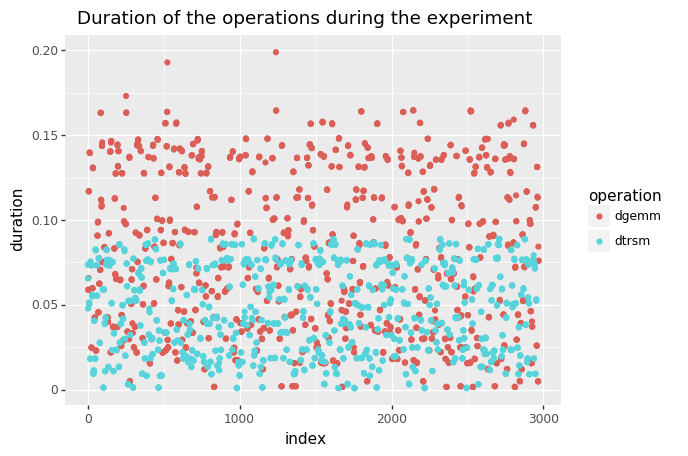

<ggplot: (8773087300286)>

In [2]:
ggplot(result_multicore, aes(x='index', y='duration', color='operation')) + geom_point() + ggtitle('Duration of the operations during the experiment')

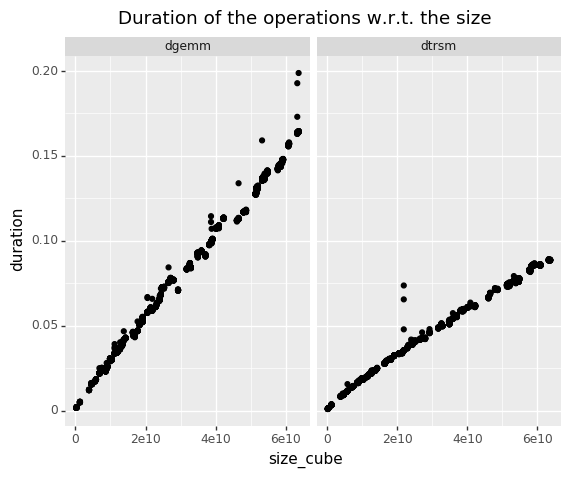

<ggplot: (-9223363263864182591)>

In [3]:
ggplot(result_multicore, aes(x='size_cube', y='duration')) + geom_point() + facet_wrap('operation') + ggtitle('Duration of the operations w.r.t. the size')

831.8970015379799


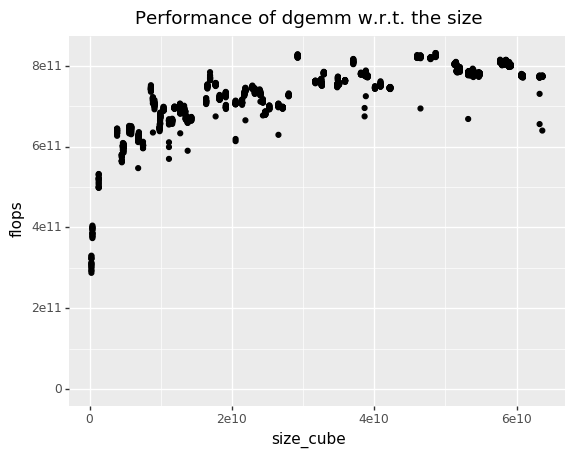

<ggplot: (8772988966555)>

In [4]:
print(get_op(result_multicore, 'dgemm').flops.max()*1e-9)
ggplot(get_op(result_multicore, 'dgemm'), aes(x='size_cube', y='flops')) + geom_point() + expand_limits(y=0) + ggtitle('Performance of dgemm w.r.t. the size')

## Monocore, with and without contention

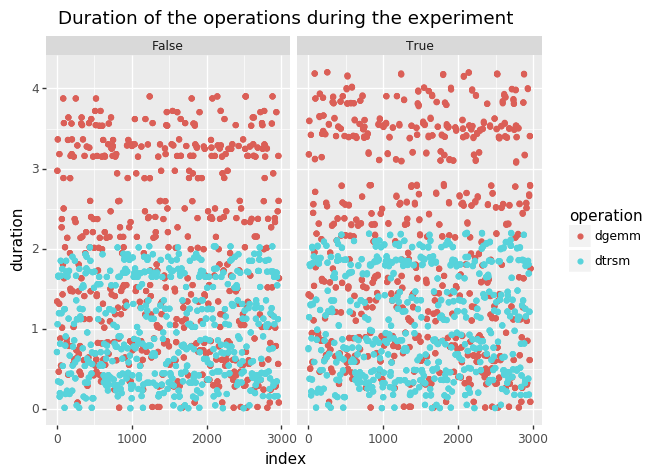

<ggplot: (8772988922902)>

In [5]:
ggplot(result_monocore, aes(x='index', y='duration', color='operation')) + geom_point() + facet_wrap('contention') + ggtitle('Duration of the operations during the experiment')

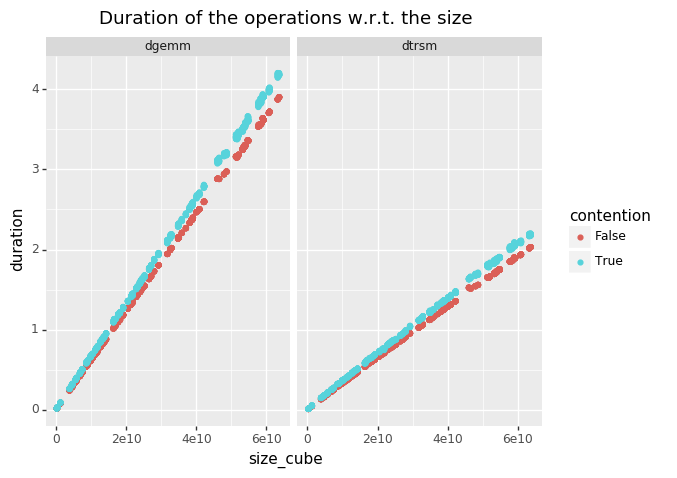

<ggplot: (-9223363263865968938)>

In [6]:
ggplot(result_monocore, aes(x='size_cube', y='duration', color='contention')) + geom_point() + facet_wrap('operation') + ggtitle('Duration of the operations w.r.t. the size')

contention
False    32.804279
True     30.783902
Name: flops, dtype: float64


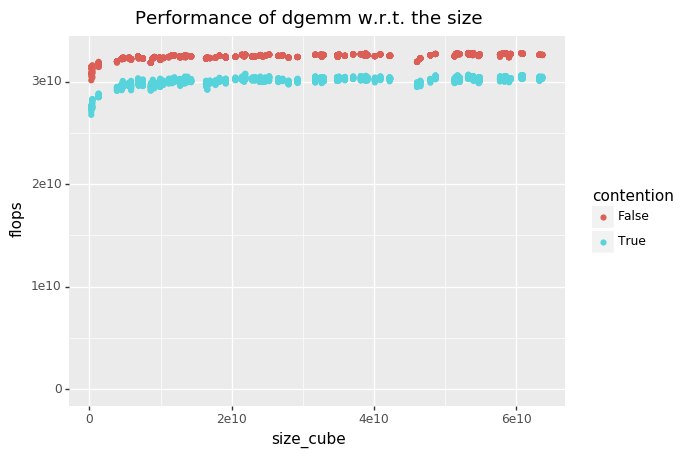

<ggplot: (-9223363263866076833)>

In [7]:
print(get_op(result_monocore, 'dgemm').groupby('contention').flops.max()*1e-9)
ggplot(get_op(result_monocore, 'dgemm'), aes(x='size_cube', y='flops', color='contention')) + geom_point() + expand_limits(y=0) + ggtitle('Performance of dgemm w.r.t. the size')

## Regression for the monocore experiment

In [8]:
import pytree
print(pytree.__git_version__)
df_dgemm = get_op(result_monocore, 'dgemm')
df_dgemm = df_dgemm[df_dgemm.contention]
reg_dgemm = pytree.compute_regression(x=df_dgemm.size_cube, y=df_dgemm.duration).auto_simplify()
reg_dgemm

0a153e9e34536887a3b697d1e0df121e8d6b9eeb


-inf < x ≤ 1.430e+10
	y ~ 6.610e-11x + 6.370e-03
1.430e+10 < x ≤ 2.654e+10
	y ~ 6.435e-11x + 4.144e-02
2.654e+10 < x ≤ 4.225e+10
	y ~ 6.494e-11x + 4.047e-02
4.225e+10 < x ≤ 4.863e+10
	y ~ 3.906e-11x + 1.302e+00
4.863e+10 < x ≤ 5.173e+10
	y ~ -2.091e-11x + 4.478e+00
5.173e+10 < x ≤ 5.392e+10
	y ~ 5.572e-11x + 5.353e-01
5.392e+10 < x ≤ inf
	y ~ 6.386e-11x + 1.219e-01

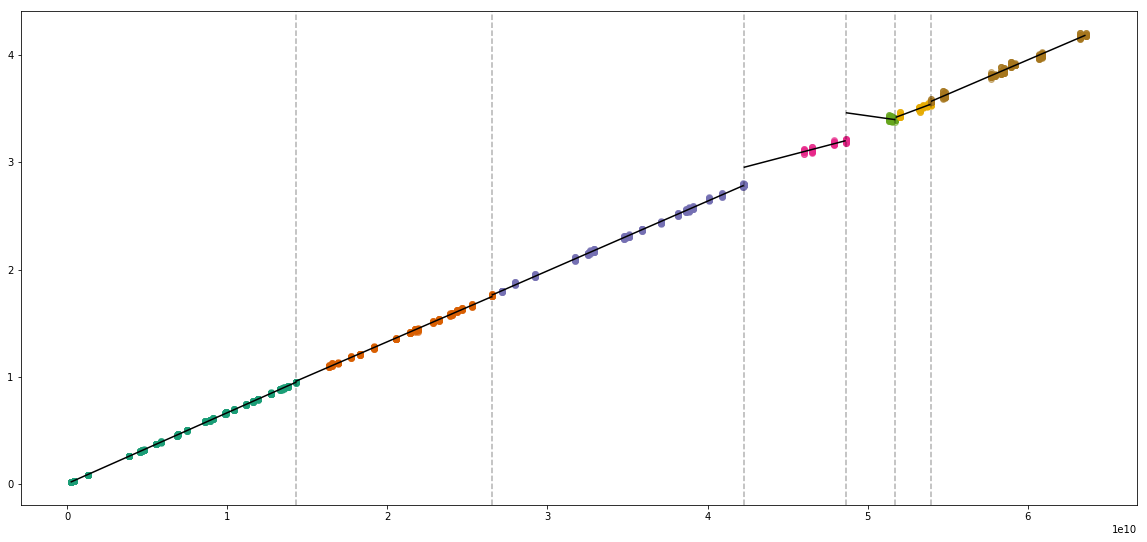

In [9]:
reg_dgemm.plot_dataset()

In [10]:
reg_dgemm.simplify()

,AIC,BIC,RSS,nb_breakpoints,regression
0,-2550.700428,-2407.514836,0.173079,6,"((267089984, 0.01928838), (267089984, 0.019313..."
1,-2501.685118,-2379.712207,0.179853,5,"((267089984, 0.01928838), (267089984, 0.019313..."
2,-2473.340732,-2372.580501,0.184310,4,"((267089984, 0.01928838), (267089984, 0.019313..."
3,-2409.268738,-2329.721187,0.193475,3,"((267089984, 0.01928838), (267089984, 0.019313..."
4,-2260.701925,-2202.367054,0.214988,2,"((267089984, 0.01928838), (267089984, 0.019313..."
5,-1851.492156,-1814.369966,0.284727,1,"((267089984, 0.01928838), (267089984, 0.019313..."
6,-1701.804541,-1685.895030,0.316625,0,"((267089984, 0.01928838), (267089984, 0.019313..."


In [11]:
simple_reg_dgemm = reg_dgemm.simplify().regression.iloc[-1].segments[0][1]
print(simple_reg_dgemm)
print(simple_reg_dgemm.coeff)
print(simple_reg_dgemm.intercept)

y ~ 6.576e-11x + 1.079e-02
6.576114746760746e-11
0.010794038141797024


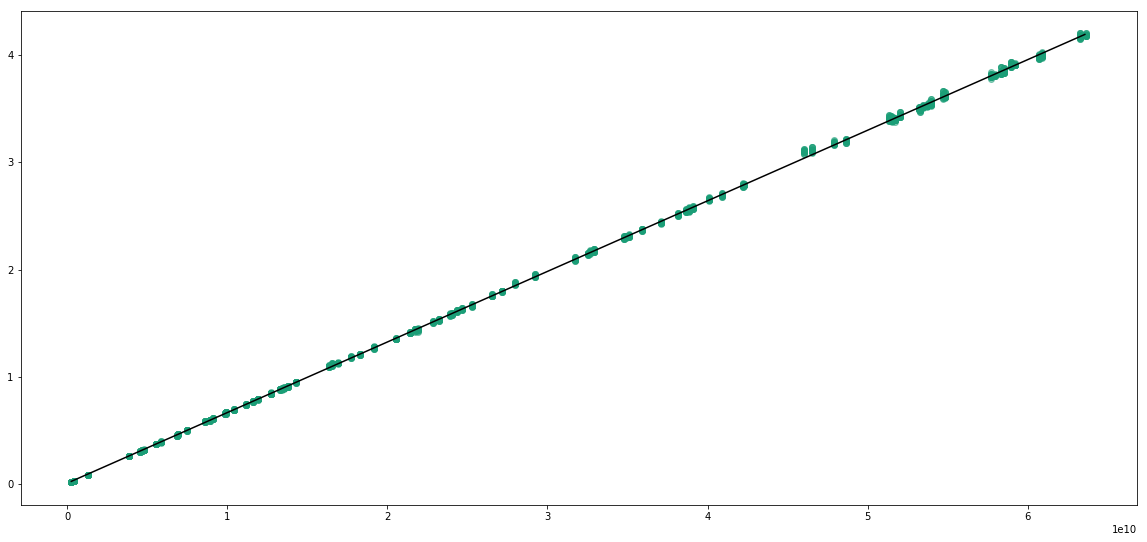

In [12]:
simple_reg_dgemm.plot_dataset()

In [13]:
df_dtrsm = get_op(result_monocore, 'dtrsm')
df_dtrsm = df_dtrsm[df_dtrsm.contention]
reg_dtrsm = pytree.compute_regression(x=df_dtrsm.size_cube, y=df_dtrsm.duration).auto_simplify()
reg_dtrsm

-inf < x ≤ 7.518e+09
	y ~ 3.618e-11x + 4.866e-03
7.518e+09 < x ≤ 1.656e+10
	y ~ 3.424e-11x + 2.277e-02
1.656e+10 < x ≤ 2.190e+10
	y ~ 3.113e-11x + 8.706e-02
2.190e+10 < x ≤ 2.798e+10
	y ~ 3.252e-11x + 6.693e-02
2.798e+10 < x ≤ 3.590e+10
	y ~ 3.153e-11x + 1.184e-01
3.590e+10 < x ≤ 4.225e+10
	y ~ 3.244e-11x + 9.640e-02
4.225e+10 < x ≤ 5.483e+10
	y ~ 2.987e-11x + 2.574e-01
5.483e+10 < x ≤ inf
	y ~ 2.953e-11x + 3.083e-01

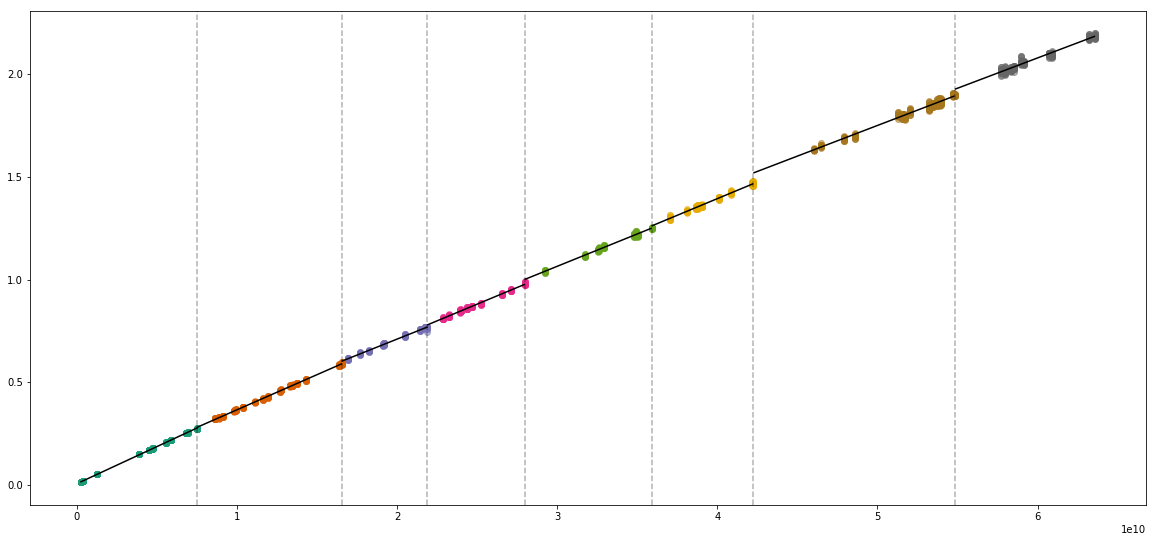

In [14]:
reg_dtrsm.plot_dataset()

In [15]:
reg_dtrsm.simplify()

,AIC,BIC,RSS,nb_breakpoints,regression
0,-3835.411057,-3671.012786,0.072475,7,"((267089984, 0.01203299), (267089984, 0.012053..."
1,-3792.573375,-3649.387784,0.074999,6,"((267089984, 0.01203299), (267089984, 0.012053..."
2,-3748.364576,-3626.391665,0.077682,5,"((267089984, 0.01203299), (267089984, 0.012053..."
3,-3703.747193,-3602.986962,0.080484,4,"((267089984, 0.01203299), (267089984, 0.012053..."
4,-3603.997297,-3524.449746,0.086541,3,"((267089984, 0.01203299), (267089984, 0.012053..."
5,-3440.808960,-3382.474090,0.097115,2,"((267089984, 0.01203299), (267089984, 0.012053..."
6,-3079.045646,-3041.923456,0.124574,1,"((267089984, 0.01203299), (267089984, 0.012053..."
7,-2734.832260,-2718.922750,0.157918,0,"((267089984, 0.01203299), (267089984, 0.012053..."


In [16]:
simple_reg_dtrsm = reg_dtrsm.simplify().regression.iloc[-1].segments[0][1]
print(simple_reg_dtrsm)
print(simple_reg_dtrsm.coeff)
print(simple_reg_dtrsm.intercept)

y ~ 3.442e-11x + 1.920e-02
3.4419129894561347e-11
0.019199531754112265


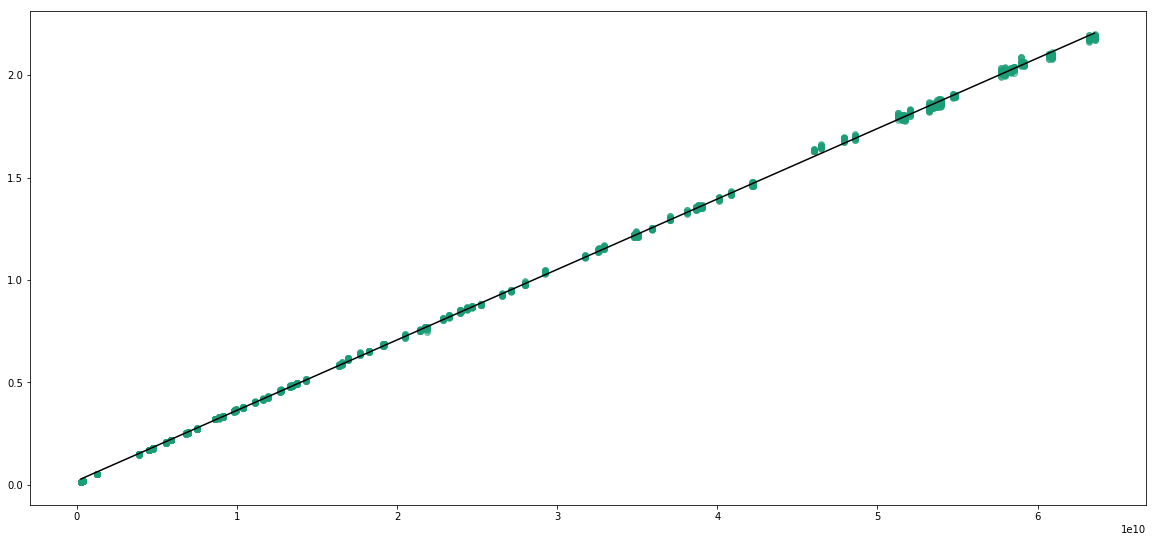

In [17]:
simple_reg_dtrsm.plot_dataset()